In [173]:
#imports:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

Abaixo estão dispostos os parâmetros que nós variamos para a execução do EP. Cada uma dessas variáveis, quando alterada, vai fornecer um novo valor e um novo gráfico, assim, podemos comparar o desempenho dos dois algoritmos em diferentes casos.

**Q-LERANING**

In [181]:
# definicao do ambiente
amb = gym.make("CartPole-v1")

#Parâmetros principais (hiperparâmetros) do código que podem ser ajutados de modo a obter diferentes resultados
EPISODIOS = 20000
QUADRO_EPISODIOS = 500
DESCONTO = 0.8
EPSILON = 0.1
LEARNING_RATE = 0.25

Aqui nós definimos quais são os valores que dão a definição do teste:
0 = a posição que o carro pode ocupar,
1 = a velocidade máxima que o carro pode atingir,
2 = o ângulo máximo que o bastão pode se inclinar,
3 = a velocidade angular máxima que o bastão pode atingir.

Esses parâmetros são fixos, definidos no enunciado do EP.

In [182]:
#definicao dos parametros do teste
amb.observation_space.high[0] = 4.8
amb.observation_space.high[1] = 10e38
amb.observation_space.high[2] = 0.418
amb.observation_space.high[3] = 10e38

amb.observation_space.low[0] = -4.8
amb.observation_space.low[1] = -10e38
amb.observation_space.low[2] = -0.418
amb.observation_space.low[3] = -10e38

Aqui nós definimos a matriz Q

In [183]:
# Configuração da Tabela Q:
# Define o tamanho da Tabela Q com base nos espaços de estados e ações do ambiente.
angulo_theta = amb.observation_space.high[2]  # Valor máximo de theta
velocidade_angular_theta = math.radians(50)  # Valor máximo de theta_dot em radianos
num_estadosD_theta = 24  # Número de estados discretos para theta
num_estadosD_VA_theta = 50  # Número de estados discretos para velocidade angular
TABELA_Q = np.random.randn(num_estadosD_theta, num_estadosD_VA_theta, amb.action_space.n)  # Inicializa a Tabela Q com valores aleatórios

Aqui são armazenadas as recompensas que mostra, para cada conjunto de episódios, qual foi a média de recompensas, a recompensa mínima e a recompensa máxima.

In [184]:
# Configuração de estatísticas:
# Inicializa listas para acompanhar recompensas de episódios e estatísticas
ep_recompensa = []
ep_recompensa_tabela = {'Episodio': [], 'media': [], 'min': [], 'max': []}

aqui nós discretizamos cada estado, afinal, como são tratados como double, é necessário discretizar cada um dos seus valores para podermos analizar.

In [185]:
# Função para discretizar o estado:
# Mapeia estados contínuos para estados discretos com base em divisões definidas
def discretizacao_estado(state):
    # state[2] -> theta
    # state[3] -> theta_dot
    estado_discreto = np.array([0, 0])  # Inicializa um array discreto

    # Divide o espaço de theta em estados discretos
    largura_angulo_theta = (angulo_theta - (-angulo_theta)) / num_estadosD_theta
    estado_discreto[0] = (state[2] - (-angulo_theta)) // largura_angulo_theta
    estado_discreto[0] = min(num_estadosD_theta - 1, max(0, estado_discreto[0]))

    # Divide o espaço de theta_dot em estados discretos
    largura_VA_theta = (velocidade_angular_theta - (-velocidade_angular_theta)) / num_estadosD_VA_theta
    estado_discreto[1] = (state[3] - (-velocidade_angular_theta)) // largura_VA_theta
    estado_discreto[1] = min(num_estadosD_VA_theta - 1, max(0, estado_discreto[1]))

    return tuple(estado_discreto.astype(np.int))

In [ ]:
# Loop do Q-Learning:
# Executa Q-Learning por um número de episódios especificado
for episodio in range(EPISODIOS):
    recompensa_episodio = 0
    estado_discreto_atual = discretizacao_estado(amb.reset())  # Inicializa o estado discreto
    flag = False
    i = 0

    if episodio % QUADRO_EPISODIOS == 0:
        status_renderizacao = True
    else:
        status_renderizacao = False

    while not flag:



        if np.random.random() > EPSILON: # Condição para Explotaçaõ
            action = np.argmax(TABELA_Q[estado_discreto_atual])  # Escolhe a ação com base na Tabela Q
        else: # Condição para exploração
            action = np.random.randint(0, amb.action_space.n)  # Escolhe uma ação aleatória

        novo_estado, recompensa, flag, _ = amb.step(action)  # Executa a ação e obtém o próximo estado e recompensa
        new_estado_discreto = discretizacao_estado(novo_estado)  # Discretiza o novo estado

        if status_renderizacao:
            amb.render()  # Renderiza o ambiente se status_renderizacao for True

        if not flag:
            valor_max_futuro = np.max(TABELA_Q[new_estado_discreto[0], new_estado_discreto[1]])
            q_atual = TABELA_Q[estado_discreto_atual[0], estado_discreto_atual[1], action]
            new_q = q_atual + LEARNING_RATE * (recompensa + DESCONTO * valor_max_futuro - q_atual)
            TABELA_Q[estado_discreto_atual[0], estado_discreto_atual[1], action] = new_q  # Atualiza os valores da Tabela Q

        if (abs(novo_estado[2]) > math.radians(12)) or (abs(novo_estado[0]) > 2.4) or (i > 500):
          flag = True

        i = i + 1
        estado_discreto_atual = new_estado_discreto
        recompensa_episodio += recompensa

    ep_recompensa.append(recompensa_episodio)

    if not episodio % QUADRO_EPISODIOS:
        media_recompensa = sum(ep_recompensa[-QUADRO_EPISODIOS:]) / len(ep_recompensa[-QUADRO_EPISODIOS:])
        ep_recompensa_tabela['Episodio'].append(episodio)
        ep_recompensa_tabela['media'].append(media_recompensa)
        ep_recompensa_tabela['min'].append(min(ep_recompensa[-QUADRO_EPISODIOS:]))
        ep_recompensa_tabela['max'].append(max(ep_recompensa[-QUADRO_EPISODIOS:]))
        print(f"episodio:{episodio} media:{media_recompensa} min:{min(ep_recompensa[-QUADRO_EPISODIOS:])} max:{max(ep_recompensa[-QUADRO_EPISODIOS:])}")

amb.close()

**SARSA**


In [ ]:
# definicao do ambiente
amb = gym.make("CartPole-v1")

# parametros a serem variados
EPISODIOS = 10000
DESCONTO = 0.95
QUADRO_EPISODIOS = 500
LEARNING_RATE = 0.65
EPSILON = 0.2

Aqui nós definimos quais são os valores que dão a definição do teste:
0 = a posição que o carro pode ocupar,
1 = a velocidade máxima que o carro pode atingir,
2 = o ângulo máximo que o bastão pode se inclinar,
3 = a velocidade angular máxima que o bastão pode atingir.

Esses parâmetros são fixos, definidos no enunciado do EP.

In [ ]:
#definicao dos parametros do teste
amb.observation_space.high[0] = 4.8
amb.observation_space.high[1] = 10e38
amb.observation_space.high[2] = 0.418
amb.observation_space.high[3] = 10e38

amb.observation_space.low[0] = -4.8
amb.observation_space.low[1] = -10e38
amb.observation_space.low[2] = -0.418
amb.observation_space.low[3] = -10e3

Aqui nós definimos a matriz Q

In [ ]:
#definicao da matriz Q
angulo_theta = amb.observation_space.high[2]
velocidade_angular_theta = math.radians(50)
num_estadosD_theta = 24
num_estadosD_VA_theta = 50
TABELA_Q = np.random.randn(num_estadosD_theta, num_estadosD_VA_theta, amb.action_space.n)

Aqui são armazenadas as recompensas que mostra, para cada conjunto de episódios, qual foi a média de recompensas, a recompensa mínima e a recompensa máxima.

In [ ]:
recompensas = []
recompensas_tabela = {'episodio': [], 'average': [], 'min': [], 'max': []}

aqui nós discretizamos cada estado, afinal, como são tratados como double, é necessário discretizar cada um dos seus valores para podermos analizar.

In [ ]:
def discretizacao_estado(state):
	#state[2] -> theta
	#state[3] -> theta_dot
	estado_discreto = np.array([0,0])		#Initialised discrete array
	largura_angulo_theta =  ( angulo_theta - (-angulo_theta) ) / num_estadosD_theta
	estado_discreto[0] = ( state[2] - (-angulo_theta) ) // largura_angulo_theta
	estado_discreto[0] = min(num_estadosD_theta-1, max(0,estado_discreto[0]))

	largura_VA_theta =  ( velocidade_angular_theta - (-velocidade_angular_theta) )/ num_estadosD_theta
	estado_discreto[1] = ( state[3] - (-velocidade_angular_theta) ) // largura_VA_theta
	estado_discreto[1] = min(num_estadosD_theta-1, max(0,estado_discreto[1]))

	return tuple(estado_discreto.astype(int))

Aqui está a implementação do algotímo SARSA

In [ ]:
# Como o texto nos slides sugere, aqui seguimos aquele passo a passo:
# primeiro fazemos o loop por episodio
for episodio in range(EPISODIOS):
	recompensa_episodio = 0
	flag = False

	if episodio % QUADRO_EPISODIOS == 0:
		status_renderizacao = True
	else:
		status_renderizacao = False

	# inicializamos os estados
	estado_discreto_atual = discretizacao_estado(amb.reset())
	if np.random.random() > EPSILON:
		action = np.argmax(TABELA_Q[estado_discreto_atual])
	else:
		action = np.random.randint(0, amb.action_space.n)

	# enquanto não tiver terminado (s != final) faz o loop entre cada passo do episódio
	while not flag:


		novo_estado, recompensa, flag, _ = amb.step(action)
		new_estado_discreto = discretizacao_estado(novo_estado)

	# aqui selecionamos a nova acao
		if np.random.random() > EPSILON:
			new_action = np.argmax(TABELA_Q[new_estado_discreto])
		else:
			new_action = np.random.randint(0, amb.action_space.n)

		if status_renderizacao:
			amb.render()

	# atualiza os valores da matriz Q
		if not flag:
			q_atual = TABELA_Q[estado_discreto_atual+(action,)]
			valor_max_futuro = TABELA_Q[new_estado_discreto+(new_action,)]
			new_q = q_atual + LEARNING_RATE*(recompensa+DESCONTO*valor_max_futuro-q_atual)
			TABELA_Q[estado_discreto_atual+(action,)]=new_q

		estado_discreto_atual = new_estado_discreto
		action = new_action

		recompensa_episodio += recompensa

	recompensas.append(recompensa_episodio)

	#atualiza a matriz com as recompensas
	if not episodio % QUADRO_EPISODIOS:
		media_recompensa = sum(recompensas[-QUADRO_EPISODIOS:])/len(recompensas[-QUADRO_EPISODIOS:])
		recompensas_tabela['episodio'].append(episodio)
		recompensas_tabela['average'].append(media_recompensa)
		recompensas_tabela['min'].append(min(recompensas[-QUADRO_EPISODIOS:]))
		recompensas_tabela['max'].append(max(recompensas[-QUADRO_EPISODIOS:]))
		print(f"episodio:{episodio} media:{media_recompensa} min:{min(recompensas[-QUADRO_EPISODIOS:])} max:{max(recompensas[-QUADRO_EPISODIOS:])}")

amb.close()

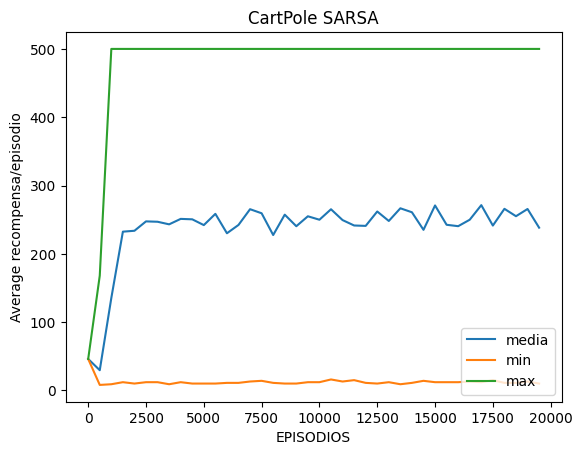

In [ ]:
#após colhermos os dados, fazemos o plot do gráfico, demonstrando, em cada intervalo de episódios, qual foi a média do valor de recompensas obtidas, e vemos que há um padrão no momento em que essa média estabiliza.
plt.plot(recompensas_tabela['episodio'], recompensas_tabela['average'], label="media")
plt.plot(recompensas_tabela['episodio'], recompensas_tabela['min'], label="min")
plt.plot(recompensas_tabela['episodio'], recompensas_tabela['max'], label="max")
plt.legend(loc=4) #bottom right
plt.title('CartPole SARSA')
plt.ylabel('Average recompensa/episodio')
plt.xlabel('EPISODIOS')
plt.show()